# Multi-Agent System with LangGraph 

In [1]:
!pip install -q langgraph langsmith langchain langchain_groq langchain_community arxiv wikipedia certifi


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
from typing import Annotated, Literal, TypedDict, List
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
import httpx
import ssl

In [3]:
# CRITICAL SSL FIX: Configure SSL to bypass certificate verification
import warnings
warnings.filterwarnings('ignore')

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Create unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

# Set environment variables to disable SSL verification
os.environ['PYTHONHTTPSVERIFY'] = '0'
os.environ['CURL_CA_BUNDLE'] = ''
os.environ['REQUESTS_CA_BUNDLE'] = ''
os.environ['SSL_CERT_FILE'] = ''

print("✓ SSL certificate verification disabled")
print("✓ Environment configured")

✓ SSL certificate verification disabled
✓ Environment configured


In [4]:
from dotenv import load_dotenv
load_dotenv()

# Get API key
groq_api = os.getenv('GROQ_API_KEY')

if not groq_api:
    raise ValueError("GROQ_API_KEY not found in environment variables")

# Create custom HTTP client that BYPASSES SSL verification
custom_http_client = httpx.Client(
    timeout=httpx.Timeout(60.0, connect=10.0),
    limits=httpx.Limits(max_keepalive_connections=5, max_connections=10),
    verify=False  # CRITICAL: Disable SSL verification
)

print("✓ HTTP client configured with SSL verification disabled")

✓ HTTP client configured with SSL verification disabled


## Define State Structure

In [5]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    current_agent: str
    research_results: str
    analysis_results: str
    next_action: str

## Initialize Tools and LLM

In [6]:
# Initialize tools
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=1000))
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=1000))

research_tools = [wikipedia, arxiv]

# Initialize LLM with SSL-bypassing HTTP client
try:
    llm = ChatGroq(
        groq_api_key=groq_api,
        temperature=0.7,
        model_name="llama-3.3-70b-versatile",
        http_client=custom_http_client  # Use our custom client that bypasses SSL
    )
    # Test the connection
    test_response = llm.invoke([HumanMessage(content="Hi")])
    print("✓ LLM initialized and tested successfully")
    print(f"✓ Test response received: {test_response.content[:50]}...")
except Exception as e:
    print(f"✗ Error initializing LLM: {e}")
    raise

✓ LLM initialized and tested successfully
✓ Test response received: It's nice to meet you. Is there something I can he...


## Define Agent Nodes

In [7]:
def coordinator_agent(state: AgentState) -> AgentState:
    """
    Coordinator Agent: Analyzes the query and routes to appropriate agents
    """
    messages = state["messages"]
    user_query = next((m.content for m in messages if isinstance(m, HumanMessage)), "")
    
    # Analyze query to determine what's needed
    analysis_prompt = f"""Analyze this query: '{user_query}'
    
Determine if this query requires:
1. RESEARCH: Looking up factual information (respond with 'RESEARCH')
2. ANALYSIS: Only analyzing or comparing existing information (respond with 'ANALYSIS')
3. BOTH: Both research and analysis (respond with 'RESEARCH')

Respond with just one word: RESEARCH or ANALYSIS"""
    
    try:
        response = llm.invoke([SystemMessage(content="You are a coordinator that routes queries to the right agents."),
                              HumanMessage(content=analysis_prompt)])
        
        decision = response.content.strip().upper()
        next_action = "research" if "RESEARCH" in decision else "analysis"
        
        return {
            "messages": [AIMessage(content=f"Routing to {next_action} agent", name="Coordinator")],
            "current_agent": "coordinator",
            "next_action": next_action
        }
    except Exception as e:
        print(f"Error in coordinator_agent: {e}")
        # Fallback to research
        return {
            "messages": [AIMessage(content=f"Routing to research agent (fallback)", name="Coordinator")],
            "current_agent": "coordinator",
            "next_action": "research"
        }

In [8]:
def research_agent(state: AgentState) -> AgentState:
    """
    Research Agent: Searches for factual information using Wikipedia and Arxiv
    """
    messages = state["messages"]
    user_query = next((m.content for m in messages if isinstance(m, HumanMessage)), "")
    
    # Ask LLM to generate search queries
    search_prompt = f"""For the query: '{user_query}'
    
Generate 1-2 search queries to find relevant information. Consider:
- Wikipedia for general knowledge, definitions, and background
- Arxiv for academic papers and research

Format your response as:
WIKIPEDIA: [search query]
ARXIV: [search query]

Only include the sources that would be helpful. Be concise."""
    
    try:
        response = llm.invoke([SystemMessage(content="You are a research specialist who determines what to search for."),
                              HumanMessage(content=search_prompt)])
        
        search_instructions = response.content
        print(f"\n🔍 Search plan:\n{search_instructions}\n")
        
        # Execute searches based on LLM's plan
        tool_results = []
        
        # Parse and execute Wikipedia searches
        if "WIKIPEDIA:" in search_instructions.upper():
            try:
                wiki_query = search_instructions.split("WIKIPEDIA:")[1].split("\n")[0].strip()
                print(f"📚 Searching Wikipedia for: {wiki_query}")
                result = wikipedia.run(wiki_query)
                tool_results.append(f"**Wikipedia Search Results:**\n{result}")
            except Exception as e:
                print(f"Wikipedia search error: {e}")
                tool_results.append(f"Wikipedia search encountered an error.")
        
        # Parse and execute Arxiv searches
        if "ARXIV:" in search_instructions.upper():
            try:
                arxiv_query = search_instructions.split("ARXIV:")[1].split("\n")[0].strip()
                print(f"📄 Searching Arxiv for: {arxiv_query}")
                result = arxiv.run(arxiv_query)
                tool_results.append(f"**Arxiv Search Results:**\n{result}")
            except Exception as e:
                print(f"Arxiv search error: {e}")
                tool_results.append(f"Arxiv search encountered an error.")
        
        research_results = "\n\n---\n\n".join(tool_results) if tool_results else "No research results found."
        
        return {
            "messages": [AIMessage(content=f"Research complete. Found relevant information.", name="Researcher")],
            "current_agent": "research",
            "research_results": research_results,
            "next_action": "analysis"
        }
    except Exception as e:
        print(f"Error in research_agent: {e}")
        return {
            "messages": [AIMessage(content=f"Research encountered an error, proceeding to analysis", name="Researcher")],
            "current_agent": "research",
            "research_results": "Research could not be completed due to an error.",
            "next_action": "analysis"
        }

In [9]:
def analysis_agent(state: AgentState) -> AgentState:
    """
    Analysis Agent: Synthesizes information and provides final answer
    """
    messages = state["messages"]
    user_query = next((m.content for m in messages if isinstance(m, HumanMessage)), "")
    research_results = state.get("research_results", "No research available")
    
    # Create comprehensive analysis
    analysis_prompt = f"""User Query: {user_query}
    
Research Findings:
{research_results}

Based on the above research, provide a comprehensive answer to the user's query.
Structure your response clearly with:
1. Direct answer to the query
2. Key supporting details
3. Relevant examples or applications
4. Any important caveats or additional context

Be thorough but concise."""
    
    try:
        response = llm.invoke([SystemMessage(content="You are an analysis expert who synthesizes research into clear, comprehensive answers."),
                              HumanMessage(content=analysis_prompt)])
        
        return {
            "messages": [AIMessage(content=response.content, name="Analyst")],
            "current_agent": "analysis",
            "analysis_results": response.content,
            "next_action": "end"
        }
    except Exception as e:
        print(f"Error in analysis_agent: {e}")
        return {
            "messages": [AIMessage(content="Analysis could not be completed due to an error.", name="Analyst")],
            "current_agent": "analysis",
            "analysis_results": "Analysis could not be completed due to an error.",
            "next_action": "end"
        }

## Define Routing Logic

In [10]:
def route_agent(state: AgentState) -> Literal["coordinator", "research", "analysis", "end"]:
    """
    Determines which agent to route to based on current state
    """
    next_action = state.get("next_action", "coordinator")
    
    if next_action == "end":
        return "end"
    elif next_action == "research":
        return "research"
    elif next_action == "analysis":
        return "analysis"
    else:
        return "coordinator"

## Build the Multi-Agent Graph

In [11]:
# Create the graph
workflow = StateGraph(AgentState)

# Add agent nodes
workflow.add_node("coordinator", coordinator_agent)
workflow.add_node("research", research_agent)
workflow.add_node("analysis", analysis_agent)

# Add edges
workflow.add_edge(START, "coordinator")
workflow.add_conditional_edges(
    "coordinator",
    route_agent,
    {
        "research": "research",
        "analysis": "analysis",
        "end": END
    }
)
workflow.add_conditional_edges(
    "research",
    route_agent,
    {
        "analysis": "analysis",
        "end": END
    }
)
workflow.add_edge("analysis", END)

# Compile the graph
multi_agent_system = workflow.compile()

print("✓ Multi-Agent System compiled successfully!")

✓ Multi-Agent System compiled successfully!


## Visualize the Multi-Agent System

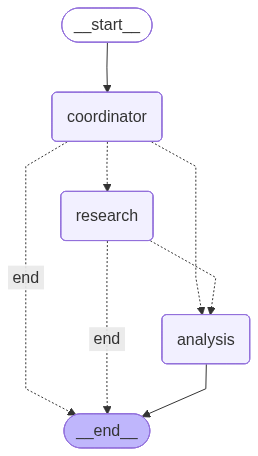

In [12]:
try:
    display(Image(multi_agent_system.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization not available: {e}")
    print("\nGraph structure:")
    print("START → coordinator → [research | analysis] → analysis → END")

## Test the Multi-Agent System

In [13]:
def run_multi_agent_query(query: str):
    """
    Run a query through the multi-agent system
    """
    print(f"\n{'='*80}")
    print(f"QUERY: {query}")
    print(f"{'='*80}\n")
    
    # Create initial state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "current_agent": "start",
        "research_results": "",
        "analysis_results": "",
        "next_action": "coordinator"
    }
    
    try:
        # Stream through the agents
        for step, state in enumerate(multi_agent_system.stream(initial_state, stream_mode="values"), 1):
            current_agent = state.get("current_agent", "unknown")
            print(f"\nStep {step} - Current Agent: {current_agent.upper()}")
            
            # Get the last message
            if state.get("messages"):
                last_msg = state["messages"][-1]
                if hasattr(last_msg, 'name'):
                    print(f"Agent: {last_msg.name}")
                print(f"Message: {last_msg.content[:200]}..." if len(last_msg.content) > 200 else f"Message: {last_msg.content}")
        
        # Print final results
        final_state = state
        print(f"\n{'='*80}")
        print("FINAL ANSWER:")
        print(f"{'='*80}")
        print(final_state.get("analysis_results", "No analysis available"))
        print(f"\n{'='*80}\n")
        
        return final_state
    except Exception as e:
        print(f"\n✗ Error running query: {e}")
        import traceback
        traceback.print_exc()
        return None

In [14]:
# Test 1: Research-heavy query
result1 = run_multi_agent_query("What is quantum computing and what are its potential applications?")


QUERY: What is quantum computing and what are its potential applications?


Step 1 - Current Agent: START
Agent: None
Message: What is quantum computing and what are its potential applications?

Step 2 - Current Agent: COORDINATOR
Agent: Coordinator
Message: Routing to research agent

🔍 Search plan:
WIKIPEDIA: quantum computing
ARXIV: quantum computing applications

📚 Searching Wikipedia for: quantum computing
📄 Searching Arxiv for: quantum computing applications

Step 3 - Current Agent: RESEARCH
Agent: Researcher
Message: Research complete. Found relevant information.

Step 4 - Current Agent: ANALYSIS
Agent: Analyst
Message: **1. Direct Answer to the Query:**
Quantum computing refers to a type of computation that leverages the principles of quantum mechanics, such as superposition and entanglement, to perform calculations...

FINAL ANSWER:
**1. Direct Answer to the Query:**
Quantum computing refers to a type of computation that leverages the principles of quantum mechanics, such as s

In [15]:
# Test 2: Another research query
result2 = run_multi_agent_query("Explain the concept of artificial general intelligence")


QUERY: Explain the concept of artificial general intelligence


Step 1 - Current Agent: START
Agent: None
Message: Explain the concept of artificial general intelligence

Step 2 - Current Agent: COORDINATOR
Agent: Coordinator
Message: Routing to research agent

🔍 Search plan:
WIKIPEDIA: artificial general intelligence
ARXIV: artificial general intelligence

📚 Searching Wikipedia for: artificial general intelligence
📄 Searching Arxiv for: artificial general intelligence

Step 3 - Current Agent: RESEARCH
Agent: Researcher
Message: Research complete. Found relevant information.

Step 4 - Current Agent: ANALYSIS
Agent: Analyst
Message: **1. Direct Answer to the Query:**
Artificial general intelligence (AGI) refers to a type of artificial intelligence that matches or surpasses human capabilities across virtually all cognitive tasks. ...

FINAL ANSWER:
**1. Direct Answer to the Query:**
Artificial general intelligence (AGI) refers to a type of artificial intelligence that matches or surpass

In [16]:
# Test 3: Analysis-focused query
result3 = run_multi_agent_query("Compare the advantages and disadvantages of cloud computing")


QUERY: Compare the advantages and disadvantages of cloud computing


Step 1 - Current Agent: START
Agent: None
Message: Compare the advantages and disadvantages of cloud computing

Step 2 - Current Agent: COORDINATOR
Agent: Coordinator
Message: Routing to analysis agent

Step 3 - Current Agent: ANALYSIS
Agent: Analyst
Message: **1. Direct Answer to the Query:**
Cloud computing offers a range of advantages, including scalability, cost savings, and increased flexibility, but also has disadvantages such as security concerns, d...

FINAL ANSWER:
**1. Direct Answer to the Query:**
Cloud computing offers a range of advantages, including scalability, cost savings, and increased flexibility, but also has disadvantages such as security concerns, dependence on internet connectivity, and potential vendor lock-in. The decision to use cloud computing depends on weighing these factors against the specific needs of an organization or individual.

**2. Key Supporting Details:**
The main advantages of

In [ ]:
# EXAMPLE TRACE
# Let's trace: "What is quantum computing?"
# Step 1: START → COORDINATOR
# State = {
#   messages: [HumanMessage("What is quantum computing?")],
#   current_agent: "start",
#   research_results: "",
#   analysis_results: "",
#   next_action: "coordinator"
# }

In [ ]:
# Step 2: COORDINATOR EXECUTION
# 1. Extract query: "What is quantum computing?"
# 2. Ask LLM: "Does this need RESEARCH or ANALYSIS?"
# 3. LLM responds: "RESEARCH" (needs factual info)
# 4. Update state:
#    next_action = "research"
#    messages += [AIMessage("Routing to research agent")]

In [ ]:
# Step 3: COORDINATOR → RESEARCH (via routing)
# route_agent(state):
#   next_action = "research"
#   return "research"  # Graph routes to research node

In [ ]:
# Step 4: RESEARCH EXECUTION
# 1. Ask LLM: "What should I search for?"
# 2. LLM generates:
#    WIKIPEDIA: quantum computing
#    ARXIV: quantum computing applications
# 3. Execute searches:
#    - Wikipedia returns: "Quantum computing is..."
#    - Arxiv returns: "Recent advances in..."
# 4. Store results:
#    research_results = "**Wikipedia**...\n---\n**Arxiv**..."
# 5. Update state:
#    next_action = "analysis"

In [ ]:
# Step 5: RESEARCH → ANALYSIS
# route_agent(state):
#   next_action = "analysis"
#   return "analysis"  # Graph routes to analysis node

In [ ]:
# Step 6: ANALYSIS EXECUTION
# 1. Get research_results from state
# 2. Send to LLM:
#    "User asked: What is quantum computing?
#     Research found: [research_results]
#     Synthesize answer with structure..."
# 3. LLM generates comprehensive answer
# 4. Update state:
#    analysis_results = [comprehensive answer]
#    next_action = "end"

In [ ]:
# Step 7: ANALYSIS → END
# route_agent(state):
#   next_action = "end"
#   return "end"  # Graph ends

# Final output: analysis_results